In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import statsmodels.api as sm
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score

import itertools
import time


In [8]:
data = pd.read_csv('./data/q_data_x.csv')
X = data[['TVwatch_day', 'age', 'sex', 'marry_dummy', 'child_dummy', 'inc', 'pmoney','area_kanto', 'area_tokai', 'area_keihanshin', 
          'job_dummy1', 'job_dummy2', 'job_dummy3', 'job_dummy4', 'job_dummy5', 'job_dummy6', 'job_dummy7',
          'fam_str_dummy1', 'fam_str_dummy2', 'fam_str_dummy3', 'fam_str_dummy4']] # 共変量
Z = data['cm_dummy'] # 群別変数


In [17]:
data.columns

Index(['cm_dummy', 'gamedummy', 'area_kanto', 'area_keihan', 'area_tokai',
       'area_keihanshin', 'age', 'sex', 'marry_dummy', 'job_dummy1',
       'job_dummy2', 'job_dummy3', 'job_dummy4', 'job_dummy5', 'job_dummy6',
       'job_dummy7', 'job_dummy8', 'inc', 'pmoney', 'fam_str_dummy1',
       'fam_str_dummy2', 'fam_str_dummy3', 'fam_str_dummy4', 'fam_str_dummy5',
       'child_dummy', 'T', 'F1', 'F2', 'F3', 'M1', 'M2', 'M3', 'TVwatch_day',
       'gamesecond', 'gamecount'],
      dtype='object')

In [12]:
exog = sm.add_constant(X) # 切片の追加
logit_model = sm.Logit(endog=Z, exog=exog) # ロジスティック回帰
logit_res = logit_model.fit()


Optimization terminated successfully.
         Current function value: 0.542117
         Iterations 6


In [13]:
ps = logit_res.predict(exog)
print('AUC = {:.3f}'.format(roc_auc_score(y_true=Z, y_score=ps)))
# 出力：=> AUC = 0.792


AUC = 0.792


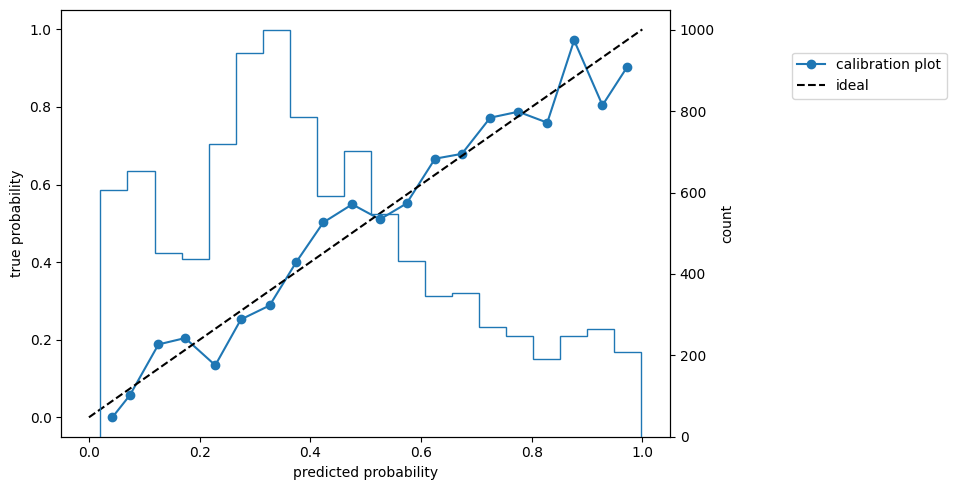

In [14]:
_, ax1 = plt.subplots(figsize=(10, 5))

prob_true, prob_pred = calibration_curve(y_true=Z, y_prob=ps, n_bins=20)
ax1.plot(prob_pred, prob_true, marker='o', label='calibration plot')
ax1.plot([0,1], [0,1], linestyle='--', color='black', label='ideal')
ax1.legend(bbox_to_anchor=(1.2, 0.9), loc='upper left', borderaxespad=0)
ax1.set_xlabel('predicted probability')
ax1.set_ylabel('true probability')

ax2 = ax1.twinx()
ax2.hist(ps, bins=20, histtype='step', rwidth=0.9)
ax2.set_ylabel('count')
plt.tight_layout()
plt.show()


In [18]:
Y = data['gamedummy'] # 結果変数（推定対象）
sample_size = len(data.loc[data['cm_dummy']==1])
ATT_list = []
epsilon = 1e-10
for i in range(10000):
    idx1 = pd.Series(data.loc[data['cm_dummy']==1, 'gamedummy'].index).sample(n=sample_size, replace=True, random_state=i)
    idx0 = pd.Series(data.loc[data['cm_dummy']==0, 'gamedummy'].index).sample(n=sample_size, replace=True, random_state=i)

    Z_tmp = np.r_[Z[idx1], Z[idx0]]
    Y_tmp = np.r_[Y[idx1], Y[idx0]]
    ps_tmp = np.r_[ps[idx1], ps[idx0]]
    w01_tmp = (1-Z_tmp)*ps_tmp/(1-ps_tmp+epsilon)

    E1 = np.mean(Y_tmp[Z_tmp==1])
    E0 = np.sum(Y_tmp * w01_tmp) / np.sum(w01_tmp)
    ATT = E1 - E0
    ATT_list.append(ATT)

print('ATT = {:.3f} ± {:.3f} (s.d.={:.3f})'.format(np.mean(ATT_list), np.std(ATT_list)*1.96, np.std(ATT_list)))
# 出力：=> ATT = 0.026 ± 0.013 (s.d.=0.006)


ATT = 0.026 ± 0.013 (s.d.=0.006)
